                    V         MA
Date                            
2014-01-02  51.332001  78.087708
2014-01-03  51.366837  77.775986
2014-01-06  51.057945  77.390289
2014-01-07  51.448132  78.468315
2014-01-08  51.613052  78.444855


<AxesSubplot:xlabel='V', ylabel='MA'>

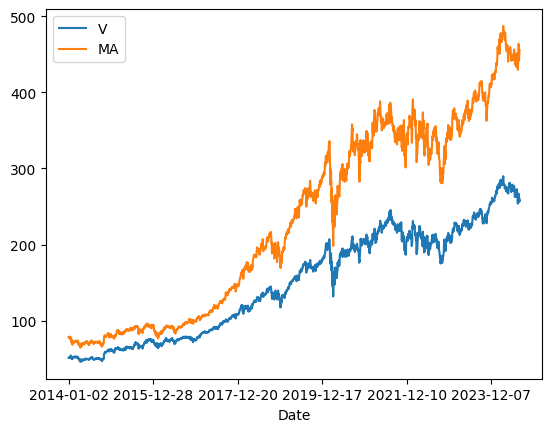

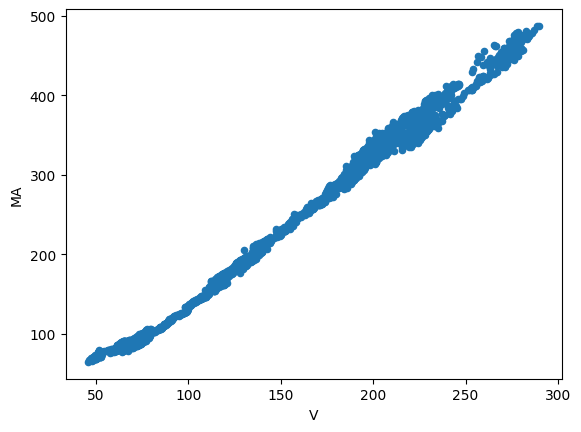

In [1]:
# Using the CADF test for cointegration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm
from yfinance_dataFetch import StockDataFetcher
import os
from datetime import datetime

def fetch_and_prepare_data(file_path, start_date, end_date, symbols=None):
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, index_col="Date")
    else:
        fetcher = StockDataFetcher(start_date=start_date, end_date=end_date, symbols=symbols)
        data = fetcher.fetch_data()
        data = data.drop(columns=data.columns[data.isna().all()])  # Drop columns with all missing values
        data.dropna(inplace=True)  # Drop rows with any missing values
        data.index.name = 'Date'
        fetcher.save_to_csv(data, file_path, index=True)
    return data


tickers = ['V', 'MA']  

df = fetch_and_prepare_data('V_MA_last_10_years.csv', "2014-01-01", datetime.now(), symbols=tickers)
print(df.head())
df.plot()
df.plot.scatter(x='V', y='MA')

Intercept    19.098802
MA            0.563127
dtype: float64
hedgeRatio=0.563127
V vs MA
t-statistic=-3.851761
[-3.90158187 -3.33899606 -3.04643897]
pvalue=0.011548


Intercept   -31.900585
V             1.759964
dtype: float64
hedgeRatio=1.759964
MA vs V
t-statistic=-3.786206
[-3.90158187 -3.33899606 -3.04643897]
pvalue=0.014141


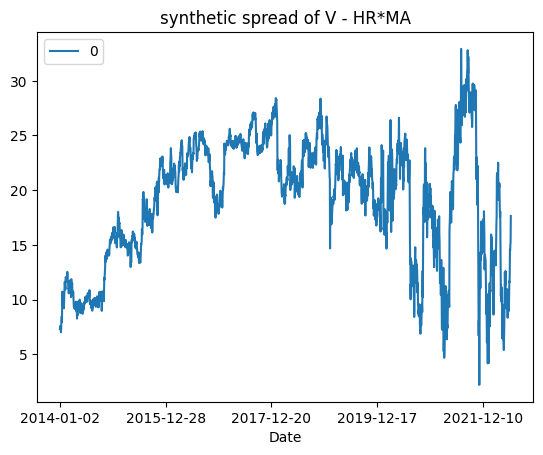

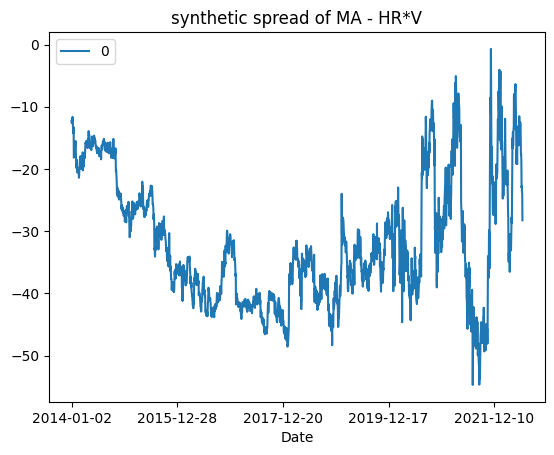

In [24]:
#plt.show()
split_index = int(len(df) * 0.8)

# Split into training and test sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]


def HR_cadf(series1, series2):
    results = sm.ols(formula=f"{series1} ~ {series2}", data=train_df[[series1, series2]]).fit()
    print(results.params)
    hedgeRatio = results.params[1]
    print('hedgeRatio=%f' % hedgeRatio)
    pd.DataFrame((train_df[series1] - hedgeRatio * train_df[series2])).plot()
    plt.title(f"synthetic spread of {series1} - HR*{series2}")
    coint_t, pvalue, crit_value = ts.coint(train_df[series1], train_df[series2])     # cadf test (make sure the 2 series cointegrate)
    print(f"{series1} vs {series2}")
    print('t-statistic=%f' % coint_t)
    print(crit_value)
    print('pvalue=%f' % pvalue)
    return hedgeRatio


hedgeRatioMA = HR_cadf("V", "MA")
print("\n")
hedgeRatioV = HR_cadf("MA", "V")

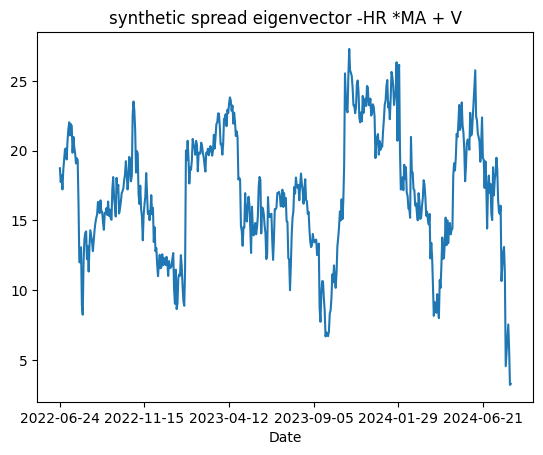

In [25]:
#yport = pd.DataFrame(np.dot(df.values, result.evec[:, 0]))  #  (net) market value of portfolio
df_hedged = test_df.copy(deep=True)
df_hedged['MA'] = df_hedged['MA'] * (-hedgeRatioMA)
yport=np.sum(df_hedged, axis=1) # -HR *MA + V
yport.plot()
plt.title("synthetic spread eigenvector -HR *MA + V")
plt.show()

In [26]:
ylag = yport.shift()
deltaY = yport - ylag
df2 = pd.concat([ylag, deltaY], axis=1)
df2.columns = ['ylag', 'deltaY']

regress_results = sm.ols(formula="deltaY ~ ylag", data=df2).fit()  # Note this can deal with NaN in top row
print(regress_results.params)

halflife = -np.log(2) / regress_results.params['ylag']
print('halflife=%f days' % halflife)

Intercept    0.777806
ylag        -0.047544
dtype: float64
halflife=14.579020 days


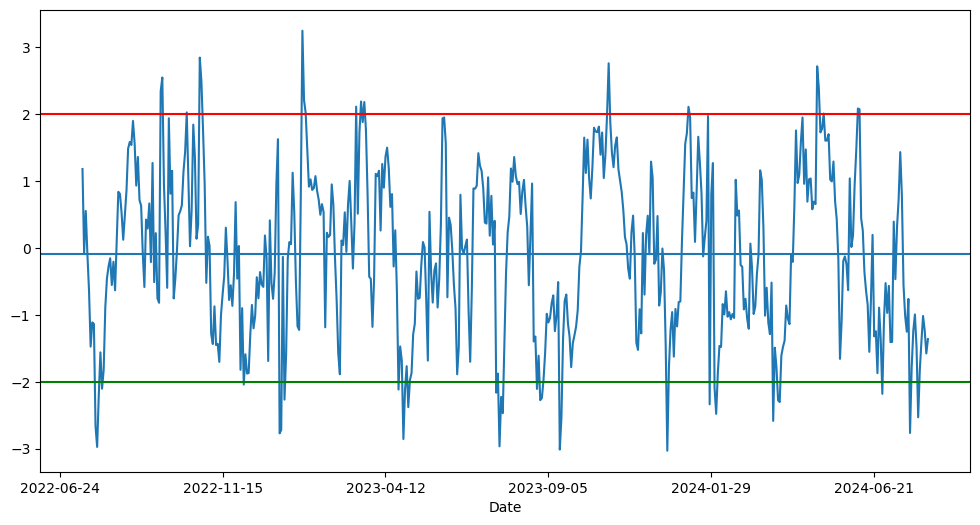

In [27]:
#  Apply a simple linear mean reversion strategy to EWA-EWC-IGE
lookback = np.round(halflife).astype(int)  #  setting lookback to the halflife found above
zscore = (yport - yport.rolling(lookback).mean()) / yport.rolling(lookback).std()  # capital invested in portfolio in dollars.  movingAvg and movingStd are functions from epchan.com/book2
zscore.plot(figsize=(12,6))
z_scoreThreshold = 2.

plt.axhline(zscore.mean())
plt.axhline(z_scoreThreshold, color='red')
plt.axhline(-z_scoreThreshold, color='green')
plt.show()

In [33]:
numUnits = -zscore
positions = df_hedged.multiply(numUnits.values, axis=0)
pnl = np.sum((positions.shift().values) * (test_df.pct_change().values), axis=1)  


APR=0.038366 Sharpe=0.769535


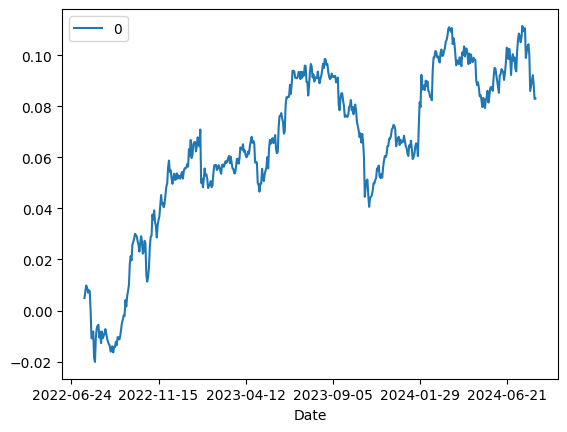

In [32]:
ret = pnl / np.sum(np.abs(positions.shift()), axis=1)
pd.DataFrame((np.cumprod(1 + ret) - 1)).plot()
print('APR=%f Sharpe=%f' % (np.prod(1 + ret) ** (252 / len(ret)) - 1, np.sqrt(252) * np.mean(ret) / np.std(ret)))
# APR=0.125739 Sharpe=1.391310